In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


### Introdução a NLP

In [3]:
# Inspecionando os dados 
social_media_dataset_path = "data/socialmedia_relevant_cols.csv"
questions = pd.read_csv(social_media_dataset_path, encoding="unicode_escape") 
questions.columns=['text', 'choose_one', 'class_label']

In [4]:
#Primeiras linhas 
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [5]:
#Últimas linhas 
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


In [6]:
questions.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [7]:
# Expressões regulares para limpeza dos dados 
def standardize_text(df, text_field):    
    df[text_field] = df[text_field].str.replace(r"http\S+", "")    
    df[text_field] = df[text_field].str.replace(r"http", "")    
    df[text_field] = df[text_field].str.replace(r"@\S+", "")    
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")    
    df[text_field] = df[text_field].str.replace(r"@", "at")    
    df[text_field] = df[text_field].str.lower()    
    return df

In [8]:
#Limpeza e regravação do arquivo de saída limpo 
clean_questions = standardize_text(questions, "text") 
clean_questions.to_csv("clean_data.csv")

In [9]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [10]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,police investigating after an e bike collided ...,Relevant,1
10873,the latest more homes razed by northern calif...,Relevant,1
10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,cityofcalgary has activated its municipal eme...,Relevant,1


In [11]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6187,6187
1,4673,4673
2,16,16


In [12]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6187,6187
1,4673,4673
2,16,16


In [13]:
from nltk.tokenize import RegexpTokenizer 
# Método de quebra dos dados 
tokenizer = RegexpTokenizer(r'\w+') 
# Gerando listas de sentenças quebradas 
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [14]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [15]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label,tokens
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw..."
10872,police investigating after an e bike collided ...,Relevant,1,"[police, investigating, after, an, e, bike, co..."
10873,the latest more homes razed by northern calif...,Relevant,1,"[the, latest, more, homes, razed, by, northern..."
10874,meg issues hazardous weather outlook (hwo),Relevant,1,"[meg, issues, hazardous, weather, outlook, hwo]"
10875,cityofcalgary has activated its municipal eme...,Relevant,1,"[cityofcalgary, has, activated, its, municipal..."


In [16]:
#Inspecioanndo novamente os dados 
all_words = [word for tokens in clean_questions["tokens"] for word in tokens] 
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]] 
VOCAB = sorted(list(set(all_words))) 
print("%s Quantidade total de palavras, com um vocabulario de %s" %(len(all_words), len(VOCAB))) 
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

154724 Quantidade total de palavras, com um vocabulario de 18101
Tamanho máximo de uma sentença 34


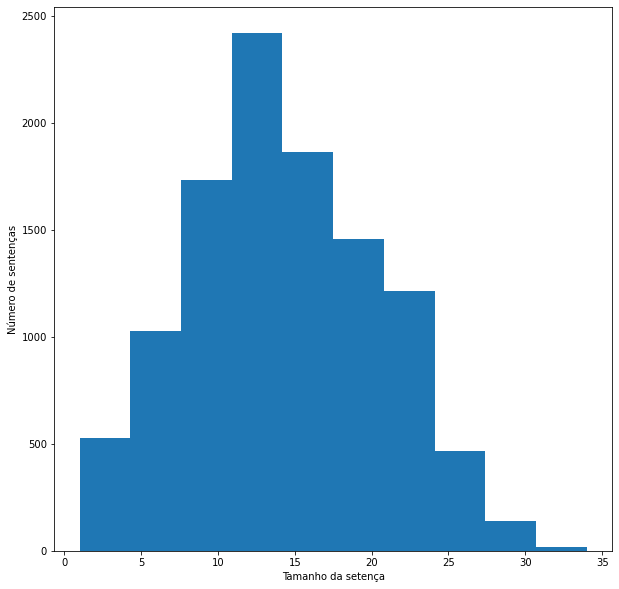

In [17]:
#Distribuilção das sentenças por quantidade de palavras 
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

### NLP e ML

In [18]:
# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 
# Separando o texto da variável alvo 
list_corpus = clean_questions["text"].tolist() 
list_labels = clean_questions["class_label"].tolist() 
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)                                                           
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

In [19]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)        
    lsa.fit(test_data)        
    lsa_scores = lsa.transform(test_data)        
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}        
    color_column = [color_mapper[label] for label in test_labels]        
    colors = ['orange','blue','blue']        
      
    if plot:            
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')            
        green_patch = mpatches.Patch(color='blue', label='Disaster')           
        plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

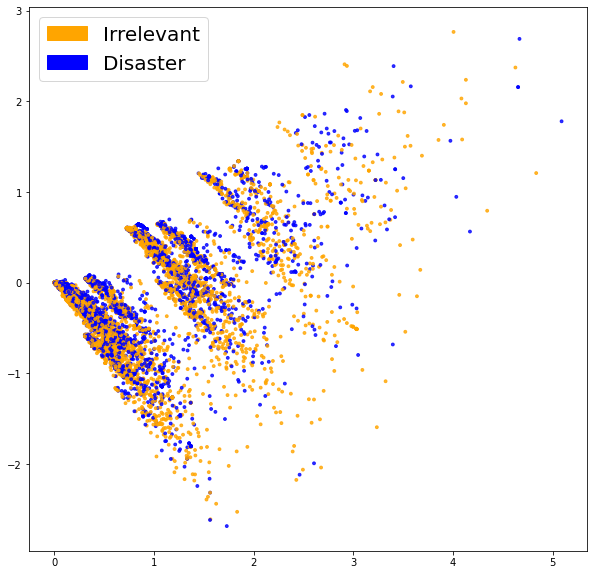

In [20]:
fig = plt.figure(figsize=(10, 10))       
plot_LSA(test_data=X_train_counts, test_labels=y_train, savepath="PCA_demo.csv", plot=True)
plt.show()

In [21]:
# Aplicando configurações no modelo 
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf.fit(X_train_counts, y_train) 
#Realizando as predições para o conjunto de teste 
y_predicted_counts = clf.predict(X_test_counts)

In [22]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste. 
def get_metrics(y_test, y_predicted):      
    # true positives / (true positives+false positives)    
    precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')                 
    # true positives / (true positives + false negatives)    
    recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')        
    # harmonic mean of precision and recall    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')        
    # true positives + true negatives/ total    
    accuracy = accuracy_score(y_test, y_predicted)    
    return accuracy, precision, recall, f1 

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


In [23]:
# Método para plotar a matriz de confusão. 
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.winter): 
    if normalize:        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title, fontsize=30)    
    plt.colorbar()    
    tick_marks = np.arange(len(classes))    
    plt.xticks(tick_marks, classes, fontsize=20)    
    plt.yticks(tick_marks, classes, fontsize=20)        
    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.     
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] < thresh else "black", fontsize=40)
        plt.tight_layout()   
        plt.ylabel('True label', fontsize=30)    
        plt.xlabel('Predicted label', fontsize=30)     
   
    return plt


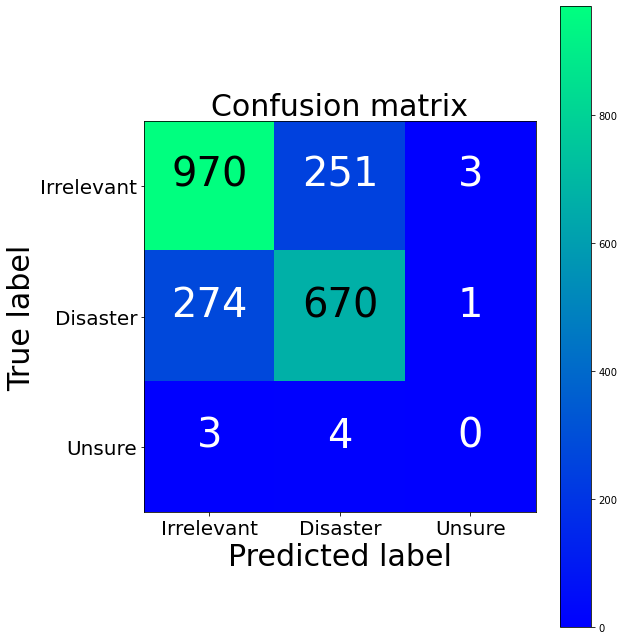

Count Vectorizer confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [24]:
cm = confusion_matrix(y_test, y_predicted_counts) 

fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 

print("Count Vectorizer confusion matrix") 
print(cm)

In [27]:
# Método para identificação das features mais importantes na tomada de decisão.
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    
    return classes 

In [28]:
importance = get_most_important_features(count_vectorizer, clf, 10)

In [29]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]       

    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 


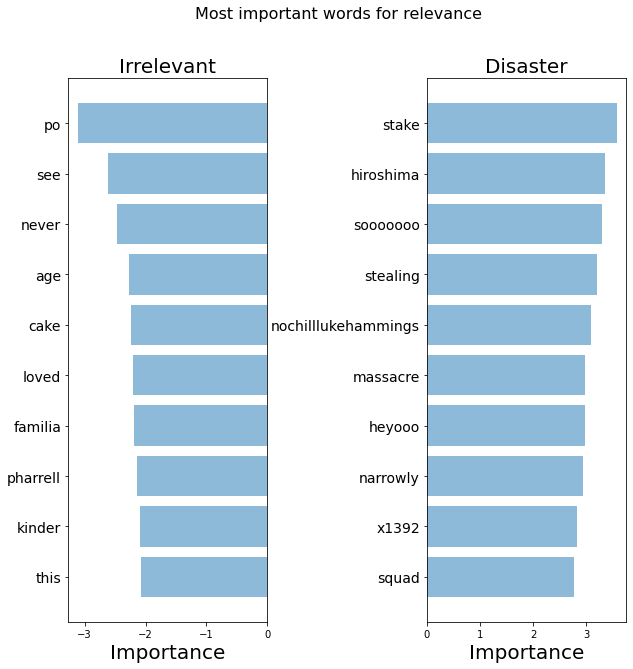

In [30]:
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

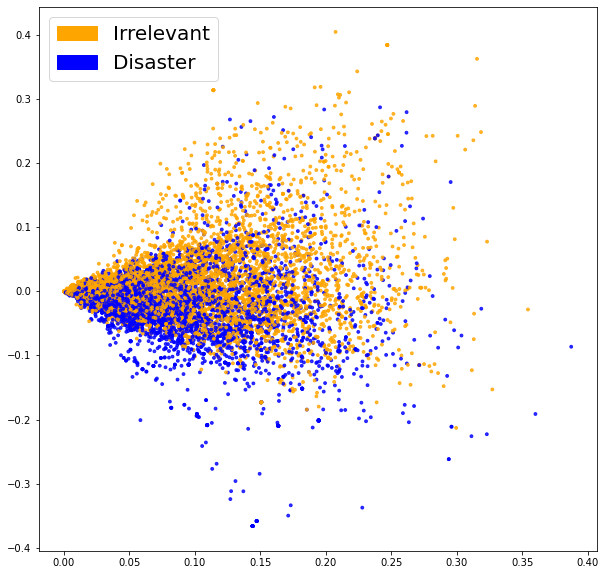

In [31]:
# Construindo bag-of-words com count-vectorizer 
tfidf_vectorizer = TfidfVectorizer() 
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_tfidf = tfidf_vectorizer.transform(X_test) 

# Plotando a distribuição do vocabulário 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train) 
plt.show()

In [32]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',                          multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf_tfidf.fit(X_train_tfidf, y_train) 
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [33]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf) 

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


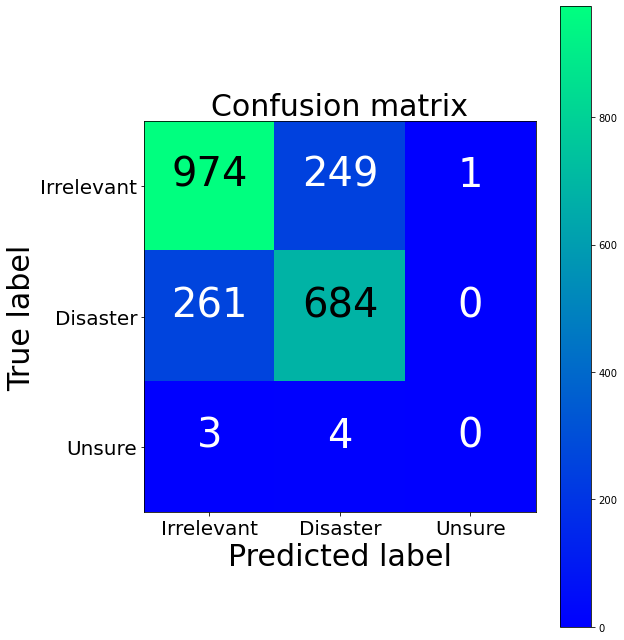

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [34]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 

fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 

print("TFIDF confusion matrix") 
print(cm2)
print("BoW confusion matrix") 
print(cm)

In [35]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

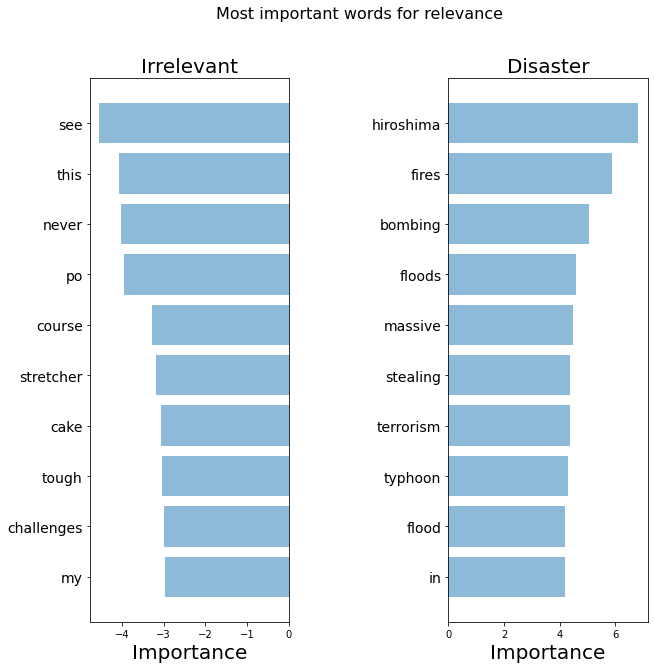

In [36]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [37]:
word2vec_path = "data/GoogleNews-vectors-negative300.bin.gz" 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [38]:
#Método para calcular a distância semântica entre as palavras 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
        return np.zeros(k)    
    if generate_missing:        
         vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
         vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    
    return averaged 

#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    
    return list(embeddings)

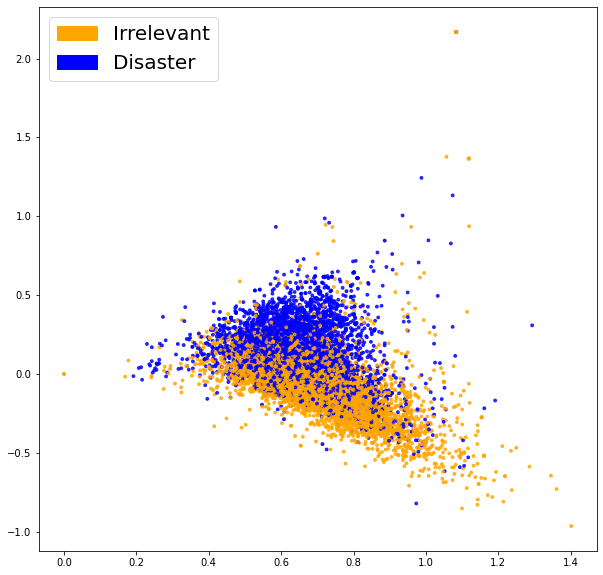

In [40]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))        
plot_LSA(embeddings, list_labels) 

plt.show()

In [41]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [42]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

accuracy = 0.777, precision = 0.776, recall = 0.777, f1 = 0.777


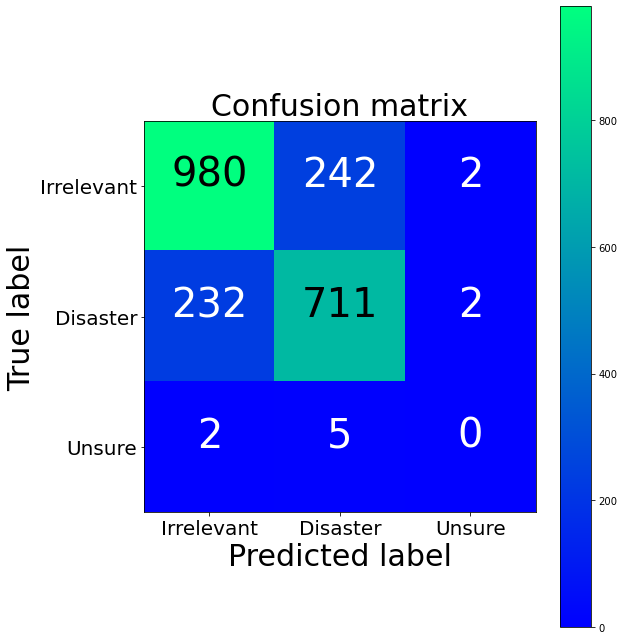

Word2Vec confusion matrix
[[980 242   2]
 [232 711   2]
 [  2   5   0]]
TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [44]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) 
print("TFIDF confusion matrix") 
print(cm2) 
print("BoW confusion matrix") 
print(cm)